In [48]:
import torch 
import pandas as pd 
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as DataLoader2
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt 
import pickle as pkl 
import seaborn as sbn 

import sys
sys.path.append('../')
from src.data.LincsDataset import LincsDataset
from src.data.pygLincsDataset import pygLincsDataset
from src.models.utils import predict_nn, predict_gsnn, predict_gnn, get_regressed_r, corr_score, regress_out, _get_regressed_metrics

In [32]:
data_ = '../output/exp1/proc/'
#uid = '../output/gsnn/09461877-9965-4dd8-a668-97f77ef73717/'
#uid = '../output/gnn/195f5d44-e89d-40a6-b561-df4675722a9c/'
uid = '../output/nn/4a98c844-1be8-48c8-9ec8-03081cb7d391/'
siginfo = '../../data/siginfo_beta.txt'
mod_name = 'model-6.pt'

In [33]:
# load model 
model = torch.load(f'{uid}/{mod_name}')
typ = str(type(model)).split('.')[-1].strip("'>")
print(typ)

NN


In [34]:
if typ == 'NN':
    predict_fn = predict_nn 
    dataset = LincsDataset
    dataloader = DataLoader
elif typ == 'GSNN': 
    predict_fn = predict_gsnn
    dataset = LincsDataset
    dataloader = DataLoader
elif typ in ['GAT', 'GIN', 'GCN']:
    predict_fn = predict_gnn 
    dataset = pygLincsDataset
    dataloader = DataLoader2
else: 
    raise ValueError(f'unrecognized model type: {args.model}')

In [35]:
# load val data 
val_ids = np.load(data_ + '/val_obs.npy', allow_pickle=True)
data = torch.load(uid + '/Data.pt')

if typ in ['GAT', 'GIN', 'GCN']:
    val_dataset = dataset(root=data_, sig_ids=val_ids, data=data)
else: 
    val_dataset = dataset(root=data_, sig_ids=val_ids)

val_loader = dataloader(val_dataset, num_workers=4, batch_size=50)

In [36]:
if torch.cuda.is_available(): 
    device = 'cuda'
else: 
    device = 'cpu'

In [37]:
y_val, yhat_val, sig_ids_val = predict_fn(val_loader, model, data, device)

In [38]:
siginfo = pd.read_csv(siginfo, low_memory=False, sep='\t')
siginfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0


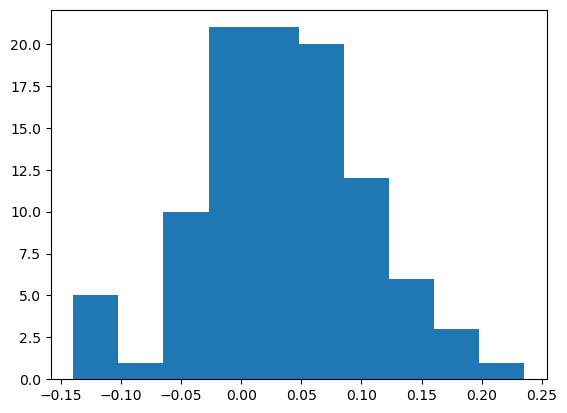

In [39]:
# gene r2s 
r_gene = corr_score(y_val, yhat_val, multioutput='raw_values')
out_names = [x.split('__')[1] for x in data.node_names[data.output_node_mask]]
r_gene_dict = {n:v for n,v in zip(out_names, r_gene)}

plt.figure()
plt.hist(r_gene_dict.values())
plt.show()

In [49]:
r_cell_, r_drug_, r_dose_ = _get_regressed_metrics(y_val, yhat_val, sig_ids_val, siginfo)

In [51]:
r_cell_

0.00039218804002738084

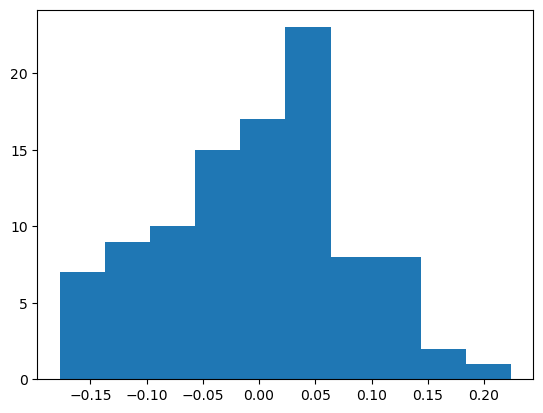

In [52]:
r_cell_gene = get_regressed_r(y_val, yhat_val, sig_ids_val, vars=['pert_id', 'pert_dose'], data='../../data/', multioutput='raw_values', siginfo=siginfo)
r_cell_gene_dict = {n:v for n,v in zip(out_names, r_cell_gene)}

plt.figure()
plt.hist(r_cell_gene_dict.values())
plt.show()

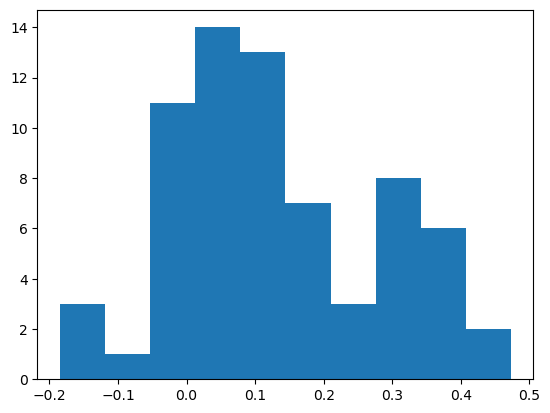

In [53]:


r_drug_dict = {}
for pid in id_info.pert_id.unique():
    mask = id_info.pert_id.values == pid
    yy = y_val[mask, :].ravel()
    yyhat = yhat_val[mask, :].ravel()

    r_drug_dict[pid] = corr_score(yy, yyhat)

plt.figure()
plt.hist(r_drug_dict.values())
plt.show()
    

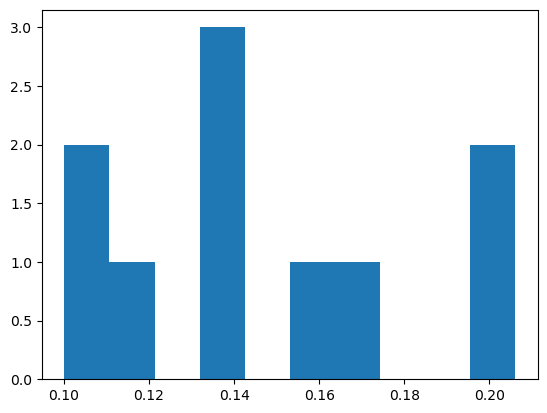

In [54]:
# drug perf 
id_info = pd.DataFrame({'sig_id':sig_ids_val}).merge(siginfo, how='left', on='sig_id')

r_cell_dict = {}
for cid in id_info.cell_iname.unique():
    mask = id_info.cell_iname.values == cid
    yy = y_val[mask, :].ravel()
    yyhat = yhat_val[mask, :].ravel()

    r_cell_dict[cid] = corr_score(yy, yyhat)

plt.figure()
plt.hist(r_cell_dict.values())
plt.show()
    

In [52]:
uid1 = '../output/gsnn/09461877-9965-4dd8-a668-97f77ef73717/'
#uid = '../output/gnn/195f5d44-e89d-40a6-b561-df4675722a9c/'
uid2 = '../output/nn/4a98c844-1be8-48c8-9ec8-03081cb7d391/'

r_gene_dict1 = pkl.load(open(f'{uid1}/r_gene_dict.pkl', 'rb'))
r_cell_gene_dict1 = pkl.load(open(f'{uid1}/r_cell_gene_dict.pkl', 'rb'))
r_cell_dict1 = pkl.load(open(f'{uid1}/r_cell_dict.pkl', 'rb'))
r_drug_dict1 = pkl.load(open(f'{uid1}/r_drug_dict.pkl', 'rb'))
res1 = [r_gene_dict1, r_cell_gene_dict1, r_cell_dict1, r_drug_dict1]

r_gene_dict2 = pkl.load(open(f'{uid2}/r_gene_dict.pkl', 'rb'))
r_cell_gene_dict2 = pkl.load(open(f'{uid2}/r_cell_gene_dict.pkl', 'rb'))
r_cell_dict2 = pkl.load(open(f'{uid2}/r_cell_dict.pkl', 'rb'))
r_drug_dict2 = pkl.load(open(f'{uid2}/r_drug_dict.pkl', 'rb'))
res2 = [r_gene_dict2, r_cell_gene_dict2, r_cell_dict2, r_drug_dict2]

res_names = ['r_gene', 'r_cell_gene', 'r_cell', 'r_drug']

In [58]:
df = pd.DataFrame(r_gene_dict1, index=[0]).T.rename({0:'model1'}, axis=1).merge(pd.DataFrame(r_gene_dict2, index=[0]).T.rename({0:'model2'}, axis=1), left_index=True, right_index=True, validate='1:1')
df = df.assign(a = lambda x: x.model1-x.model2)
df.head()


,model1,model2,a
O00233,0.002152,0.083295,-0.081143
O00273,0.005860,0.011577,-0.005717
O00429,-0.012945,0.035258,-0.048203
O14817,0.004585,-0.099504,0.104089
O43524,0.021280,0.089406,-0.068126


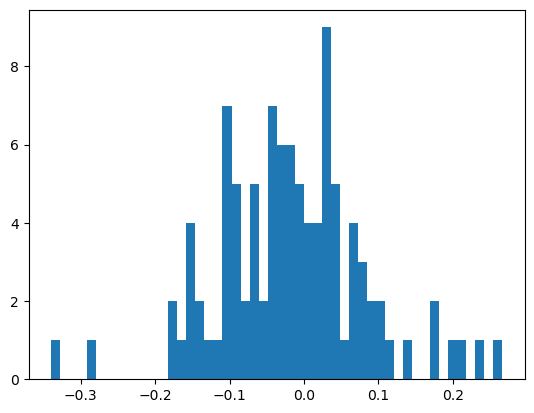

In [61]:
plt.figure()
plt.hist(df.a, bins=50)
plt.show()

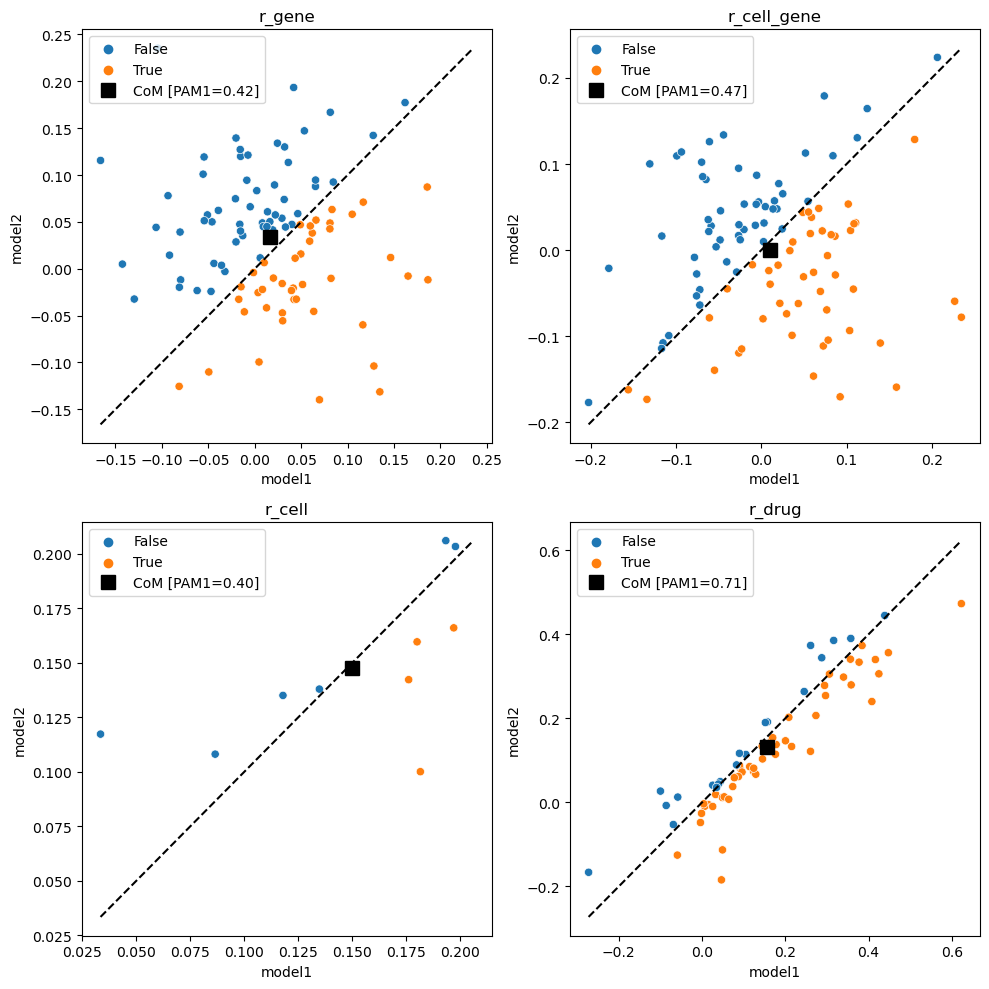

In [30]:
f, axes = plt.subplots(2,2, figsize=(10,10))

for d1, d2, name, ax in zip(res1, res2, res_names, axes.flat): 

    x = name+'_1'
    y =  name+'_2'
    df = pd.DataFrame(d1, index=[0]).T.rename({0:x}, axis=1).merge(pd.DataFrame(d2, index=[0]).T.rename({0:y}, axis=1), left_index=True, right_index=True, validate='1:1')
    df = df.assign(M1_adv = lambda l: l[x] >= l[y])
    min_ = min(df[x].values.tolist() + df[y].values.tolist())
    max_ = max(df[x].values.tolist() + df[y].values.tolist())
    ax.plot((min_,max_), (min_, max_), 'k--')
    sbn.scatterplot(x=x, y=y, data=df, ax=ax, hue='M1_adv')

    # center of mass 
    ax.plot(df[x].values.mean(), df[y].values.mean(), 'ks', markersize=10, label=f'CoM [PAM1={df.M1_adv.mean():.2f}]')
    ax.legend()
    ax.set_xlabel('model1')
    ax.set_ylabel('model2')
    ax.set_title(name)

plt.tight_layout()
plt.show()

<Axes: xlabel='r_gene_1', ylabel='r_gene_2'>

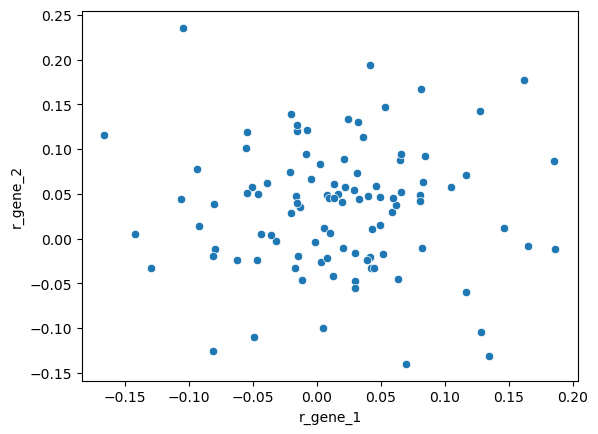

In [13]:
x = name+'_1'
y =  name+'_2'
df = pd.DataFrame(d1, index=[0]).T.rename({0:x}, axis=1).merge(pd.DataFrame(d2, index=[0]).T.rename({0:y}, axis=1), left_index=True, right_index=True, validate='1:1')


sbn.scatterplot(x=x, y=y, data=df)

